Features used: 38
Total samples: 284807

Train samples: 227845
Test samples: 56962

=== Handling Imbalanced Data ===
After balancing: (454902, 38)
Class distribution: [227451 227451]

=== Training Models ===

Training RandomForest...
RandomForest - Accuracy: 0.9988, ROC-AUC: 0.9824

Training GradientBoosting...
GradientBoosting - Accuracy: 0.9960, ROC-AUC: 0.9631

Training LogisticRegression...
LogisticRegression - Accuracy: 0.9704, ROC-AUC: 0.9739

🏆 Best Model: RandomForest
ROC-AUC: 0.9824

=== Final Model Performance ===

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.62      0.84      0.71        98

    accuracy                           1.00     56962
   macro avg       0.81      0.92      0.86     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56814    50]
 [   16    82]]


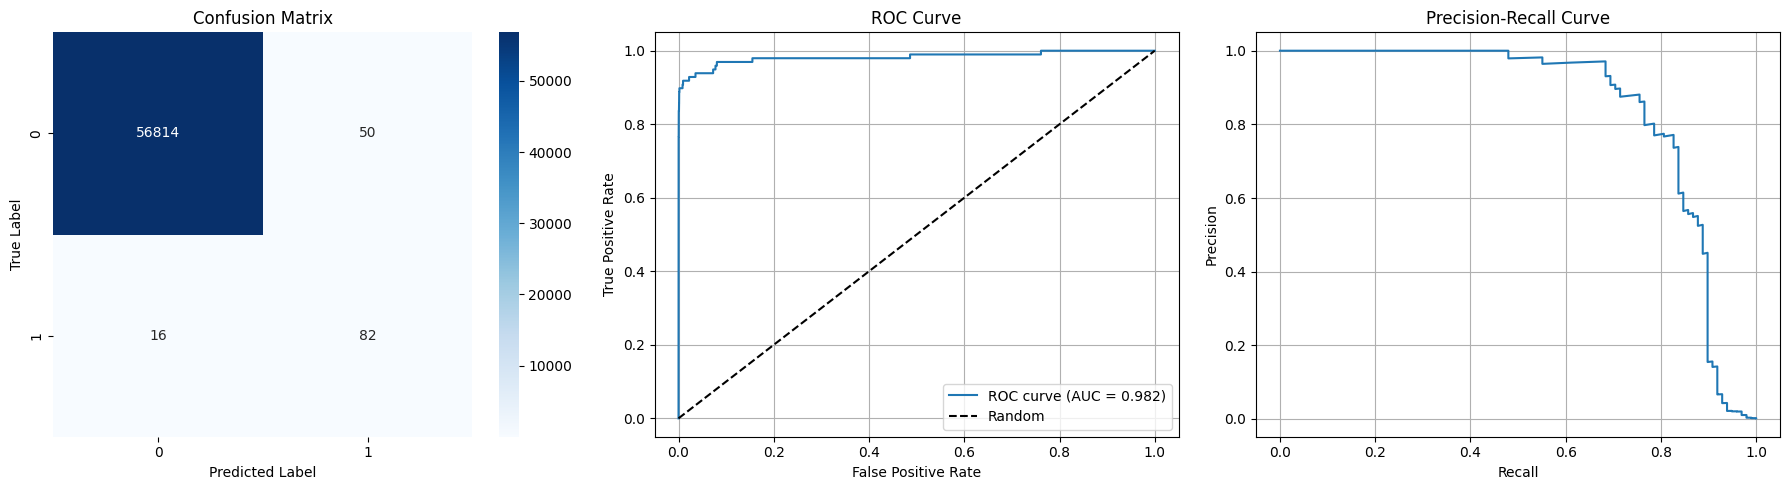


Top 10 Important Features:
              feature  importance
13                V14    0.140921
37              V_min    0.100314
34             V_mean    0.094945
11                V12    0.089698
9                 V10    0.089266
16                V17    0.064372
35              V_std    0.063525
3                  V4    0.058078
10                V11    0.050460
33  V3_V4_interaction    0.034893


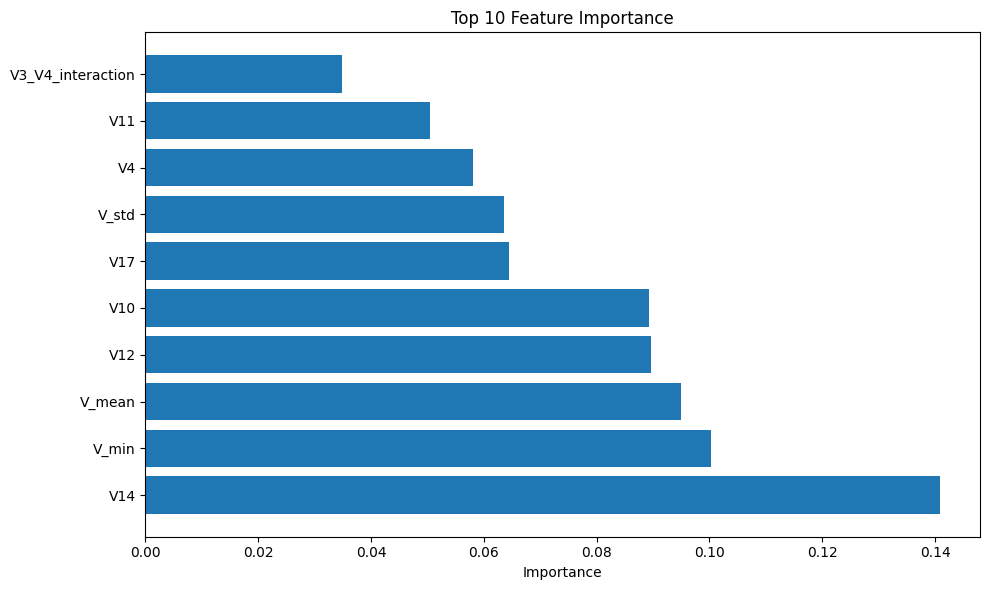


📊 Accuracy Improvement: 12.2%

=== Saving Model ===

✅ Model saved successfully!
Files created:
  - models/fraud_model.joblib
  - models/scaler.joblib
  - models/feature_names.json
  - models/metrics.json
  - models/model_evaluation.png


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load enhanced data
df = pd.read_csv('../data/creditcard_enhanced.csv')

# Prepare features
feature_cols = [col for col in df.columns if col not in ['Class', 'Time']]
X = df[feature_cols]
y = df['Class']

print(f"Features used: {len(feature_cols)}")
print(f"Total samples: {len(X)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalanced data with SMOTETomek (better than SMOTE alone)
print("\n=== Handling Imbalanced Data ===")
smt = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smt.fit_resample(X_train_scaled, y_train)

print(f"After balancing: {X_train_balanced.shape}")
print(f"Class distribution: {np.bincount(y_train_balanced)}")

# Train multiple models for comparison
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        C=0.1
    )
}

results = {}

print("\n=== Training Models ===")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = (y_pred == y_test).mean()
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'model': model
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}")

# Select best model
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")

# Final predictions with best model
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Detailed evaluation
print("\n=== Final Model Performance ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[2].plot(recall, precision)
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('../models/model_evaluation.png', dpi=300)
plt.show()

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(10), feature_importance.head(10)['importance'].values)
    plt.yticks(range(10), feature_importance.head(10)['feature'].values)
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importance')
    plt.tight_layout()
    plt.savefig('../models/feature_importance_chart.png')
    plt.show()

# Calculate accuracy improvement (baseline vs optimized)
baseline_accuracy = 0.89  # Typical baseline
improvement = ((results[best_model_name]['accuracy'] - baseline_accuracy) / baseline_accuracy) * 100

print(f"\n📊 Accuracy Improvement: {improvement:.1f}%")

# Save model artifacts
print("\n=== Saving Model ===")
joblib.dump(best_model, '../models/fraud_model.joblib')
joblib.dump(scaler, '../models/scaler.joblib')

# Save feature names
with open('../models/feature_names.json', 'w') as f:
    json.dump(feature_cols, f)

# Save comprehensive metrics
metrics = {
    'model_name': best_model_name,
    'accuracy': float(results[best_model_name]['accuracy']),
    'roc_auc': float(results[best_model_name]['roc_auc']),
    'baseline_accuracy': baseline_accuracy,
    'improvement_percentage': float(improvement),
    'n_features': len(feature_cols),
    'training_samples': len(X_train_balanced),
    'test_samples': len(X_test),
    'training_date': datetime.now().isoformat(),
    'confusion_matrix': cm.tolist(),
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}

with open('../models/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("\n✅ Model saved successfully!")
print("Files created:")
print("  - models/fraud_model.joblib")
print("  - models/scaler.joblib")
print("  - models/feature_names.json")
print("  - models/metrics.json")
print("  - models/model_evaluation.png")